In [43]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
from scipy import optimize
import time
import functools
from multiprocessing import Pool
#from cyipopt import minimize_ipopt
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import random

random.seed(10)



In [44]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/data"

In [45]:

df = pd.read_csv(os.path.join(input_dir,r"welfare_data_with_exante_ratings_update_ch3.csv"))


In [46]:
list(df.columns)

['post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_star',
 'tot

In [47]:
df_ne = pd.read_csv(r"df_ne.csv")

In [48]:
df_ne = df_ne.drop(["exante_rating",\
                    "exante_rating_random",\
                    "exante_rating_baseline",\
                   "exante_rating_const",\
                   "exante_rating_obs"], axis=1)

In [49]:
#df_ne = df_ne.merge(df[["shareid","year","month","exante_rating_baseline",\
                     #   "exante_rating_random","exante_rating_obs","exante_rating_const","exante_rating_obs_less"]], on=["shareid","year","month"])

In [50]:
df_ne = df_ne.merge(df[["shareid","year","month","operation",\
                        "exante_rating_baseline","exante_rating_obs_less","exante_rating_obs_less_brand"]], on=["shareid","year","month"])

In [51]:
#Specify exante_rating

df_ne["exante_rating"] = df_ne["exante_rating_baseline"]
#df_ne["exante_rating"] = df_ne["exante_rating_random"]
#df_ne["exante_rating"] = df_ne["exante_rating_obs"]
#df_ne["exante_rating"] = df_ne["exante_rating_const"]
#df_ne["exante_rating"] = 1
#df_ne["exante_rating"] = df_ne["exante_rating_obs_less"]

#df_ne["exante_rating"] = df_ne["exante_rating_op"]
#df_ne["exante_rating"] = df_ne["exante_rating_op_chain"]
#df_ne["exante_rating"] = df_ne["exante_rating_op_chain_national"]

In [52]:
df_ne.shape

(5597, 148)

In [53]:

# Calculate counterfactual market share


alpha = -0.012
sigma = 0.5396
rating_param_chain = 0.075-0.016
rating_param_ind = 0.075

In [60]:
def moment_cf_price(r,data):
    # r is the vector of prices
    data["delta_cf_ne_temp"] = data["delta_ne"]-alpha*(data["price_ne"]-r)
    
    data_chain = data[data["operation"]=='Chain_affiliated'].reset_index().drop(["index"],axis=1)
    data_ind = data[data["operation"]=='Independent'].reset_index().drop(["index"],axis=1)
    
    data_chain["delta_cf_ne"] = data_chain["delta_cf_ne_temp"]-rating_param_chain*(data_chain["Rating"] - data_chain["exante_rating"])
    data_ind["delta_cf_ne"] = data_ind["delta_cf_ne_temp"]-rating_param_ind*(data_ind["Rating"] - data_ind["exante_rating"])
    
    data = pd.concat([data_chain, data_ind],axis=0).reset_index().drop(["index"],axis=1)
    
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_cf_ne"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_cf_ne"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_cf_ne"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_cf_ne"]+1))
    
    df_temp["demand_cf_ne"] = df_temp["market_share_cf_ne"]*df_temp["market_size"]
    df_temp["occ_ne"] = (df_temp["demand_cf_ne"]*100/30)/df_temp["capacity"]
    

    df_temp_lower = df_temp[df_temp["demand_cf_ne"]<=df_temp["q_upper"]]
    #df_temp_middle = df_temp[(df_temp["demand_cf_ne"]>df_temp["q_upper_1"])&(df_temp["demand_cf_ne"]<=df_temp["q_upper_2"])]
    df_temp_upper = df_temp[df_temp["demand_cf_ne"]>df_temp["q_upper"]]

    df_temp_lower["excess_demand"] = 0
    #df_temp_lower["excess_demand_2"] = 0

    #df_temp_middle["excess_demand_1"] = df_temp_middle["demand_cf_ne"]-df_temp_middle["q_upper_1"]
    #df_temp_middle["excess_demand_2"] = 0

    #df_temp_upper["excess_demand_1"] = df_temp_upper["q_upper_2"]-df_temp_upper["q_upper_1"]
    df_temp_upper["excess_demand"] = df_temp_upper["demand_cf_ne"]-df_temp_upper["q_upper"]


    df_temp = pd.concat([df_temp_lower,df_temp_upper],axis=0)
    
    #df_temp_l["occ_greater_upper"] = df_temp["occ_ne"]>95
    #df_temp["excess_demand_ne"] = df_temp["demand_cf_ne"]-df_temp["q_upper"]
    #df_temp["excess_demand_interaction_ne"] = df_temp["excess_demand_ne"]*df_temp["occ_greater_upper"]
    data = df_temp.fillna(0)
    
    data["mc"] = 0.043841100663268406*data["excess_demand"]+\
                 192.39814102368837+data["hotel_fixed_effect"]+data["market_time_fixed_effect"]

    
    
    test = data.groupby(["month","year","Class Group"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"group_share_cf_ne"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_cf_ne"].sum().reset_index().rename(columns={"market_share_cf_ne":"market_share_sum_cf_ne"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_ne"] = 1-data["market_share_sum_cf_ne"]      

    df_2 = data.fillna(0)


    mom_cond = r-df_2["mc"]+\
                                1/(alpha*(1/(1-sigma)-\
                                (sigma*df_2["group_share_cf_ne"]/(1-sigma))-\
                                df_2["market_share_cf_ne"]))

    
    
    return np.mean((mom_cond)**2)


In [61]:
groups = df_ne.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:

    res = optimize.minimize(moment_cf_price, args=(g), x0=g["ADR"], bounds = [(0,10000)]*len(g),options={'disp': True})
    g["price_cf"] = res.x
    l.append(g)    
    print("{}----{}----{}".format(*[name[0],name[1],name[2]]))



end = time.time()
print("--- %s seconds ---" % (end - start))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16531D+03    |proj g|=  4.71764D+00

At iterate    1    f=  4.01661D+03    |proj g|=  4.63183D+00


/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/juju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



At iterate    2    f=  3.57066D+03    |proj g|=  3.82658D+01

At iterate    3    f=  3.55873D+03    |proj g|=  3.80765D+01

At iterate    4    f=  3.47513D+03    |proj g|=  4.10153D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  111      5     58      6     0     0   4.102D+01   3.475D+03
  F =   3475.1331336326248     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47557D+03    |proj g|=  4.60404D+00

At iterate    1    f=  4.31004D+03    |proj g|=  4.52610D+00

At iterate    2    f=  4.14569D+03    |proj g|=  3.91510D+01

At iterate    3    f=  4.00000D+03    |proj g|=  3.85854D+01

At iterate    4    f=  3.95701D+03    |proj g|=  3.82461D+01

At iterate    5    f=  3.54980D+03    |proj g|=  4.07713D+00

At iterate    6    f=  3.48322D+03    |proj g|=  4.04011D+00

At iterate    7    f=  3.48133D+03    |proj g|=  4.03870D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  111      8     85      9     0     0   4.039D+00   3.481D+03
  F =   3481.3264720087868     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74852D+03    |proj g|=  1.38686D+01

At iterate    1    f=  4.74498D+03    |proj g|=  5.87087D+00

At iterate    2    f=  4.58336D+03    |proj g|=  3.51789D+01

At iterate    3    f=  4.52887D+03    |proj g|=  3.36876D+01

At iterate    4    f=  4.52811D+03    |proj g|=  3.36756D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  111      5     79      6     0     0   3.368D+01   4.528D+03
  F =   4528.1051265487686     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.65641D+03    |proj g|=  3.54232D+01

At iterate    1    f=  4.69309D+03    |proj g|=  9.27126D+01

At iterate    2    f=  4.64548D+03    |proj g|=  7.53304D+01

At iterate    3    f=  4.64430D+03    |proj g|=  7.50004D+01

At iterate    4    f=  4.58596D+03    |proj g|=  2.00468D+01

At iterate    5    f=  4.57490D+03    |proj g|=  1.87935D+01

At iterate    6    f=  4.57466D+03    |proj g|=  1.87757D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----4
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  112      7     89      8     0     0   1.878D+01   4.575D+03
  F =   4574.6637440781860     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          112     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69846D+03    |proj g|=  6.62137D+01

At iterate    1    f=  5.53586D+03    |proj g|=  3.68454D+01

At iterate    2    f=  5.51531D+03    |proj g|=  3.59307D+01

At iterate    3    f=  5.24737D+03    |proj g|=  8.27802D+01

At iterate    4    f=  5.14481D+03    |proj g|=  8.31093D+01

At iterate    5    f=  4.81389D+03    |proj g|=  1.93364D+01

At iterate    6    f=  4.80604D+03    |proj g|=  1.89226D+01

At iterate    7    f=  4.67734D+03    |proj g|=  1.62609D+01

At iterate    8    f=  4.60789D+03    |proj g|=  2.15360D+01

At iterate    9    f=  4.60285D+03    |proj g|=  2.12769D+01

At iterate   10    f=  4.60275D+03    |proj g|=  2.12739D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----5
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  112     11    118     12     0     0   2.127D+01   4.603D+03
  F =   4602.7533392372707     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38177D+03    |proj g|=  8.00737D+01

At iterate    1    f=  5.32406D+03    |proj g|=  5.61160D+01

At iterate    2    f=  5.30131D+03    |proj g|=  3.73837D+01

At iterate    3    f=  5.03658D+03    |proj g|=  5.34756D+01

At iterate    4    f=  4.74398D+03    |proj g|=  3.73032D+01

At iterate    5    f=  4.70266D+03    |proj g|=  2.91604D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  4.69945D+03    |proj g|=  2.87144D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    7    f=  4.69942D+03    |proj g|=  2.87106D+01

At iterate    8    f=  4.69942D+03    |proj g|=  2.87105D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----6

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  113      9    154     12     0     0   2.871D+01   4.699D+03
  F =   4699.4171102931959     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          113     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13940D+03    |proj g|=  4.75369D+01

At iterate    1    f=  5.06495D+03    |proj g|=  6.67186D+01

At iterate    2    f=  4.62774D+03    |proj g|=  2.37494D+01

At iterate    3    f=  4.58468D+03    |proj g|=  2.23377D+01

At iterate    4    f=  4.58241D+03    |proj g|=  2.22635D+01

At iterate    5    f=  4.58222D+03    |proj g|=  2.22587D+01

At iterate    6    f=  4.53682D+03    |proj g|=  2.78192D+01

At iterate    7    f=  4.53637D+03    |proj g|=  2.77855D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----7
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  113      8    109      9     0     0   2.779D+01   4.536D+03
  F =   4536.3719984169566     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.00475D+03    |proj g|=  3.28486D+01

At iterate    1    f=  4.78682D+03    |proj g|=  4.39331D+01

At iterate    2    f=  4.55669D+03    |proj g|=  4.29702D+01

At iterate    3    f=  4.54472D+03    |proj g|=  3.56239D+01

At iterate    4    f=  4.54468D+03    |proj g|=  3.56120D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----8
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  114      5     76      6     0     0   3.561D+01   4.545D+03
  F =   4544.6846595363049     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97623D+03    |proj g|=  6.17419D+01

At iterate    1    f=  5.60560D+03    |proj g|=  1.49975D+02

At iterate    2    f=  4.94066D+03    |proj g|=  6.11238D+01

At iterate    3    f=  4.90982D+03    |proj g|=  5.64214D+01

At iterate    4    f=  4.90580D+03    |proj g|=  3.81132D+01

At iterate    5    f=  4.90539D+03    |proj g|=  3.80942D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  4.90539D+03    |proj g|=  2.54530D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----9

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114      7    113     10     0     1   2.545D+02   4.905D+03
  F =   4905.3871070868954     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          116     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04960D+03    |proj g|=  4.19931D+01

At iterate    1    f=  5.83697D+03    |proj g|=  3.90964D+01

At iterate    2    f=  5.50909D+03    |proj g|=  6.89463D+01

At iterate    3    f=  5.50202D+03    |proj g|=  6.82043D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  5.18149D+03    |proj g|=  6.35816D+01

At iterate    5    f=  5.15736D+03    |proj g|=  5.35510D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Chicago, IL----2016----10
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  116      6     99      8     0     0   5.355D+01   5.157D+03
  F =   5157.3577208838651     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          119     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91937D+03    |proj g|=  2.88576D+01

At iterate    1    f=  5.51355D+03    |proj g|=  7.75335D+01

At iterate    2    f=  5.43541D+03    |proj g|=  4.92640D+01

At iterate    3    f=  5.42716D+03    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Chicago, IL----2016----11
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  119      6     73      7     0     0   2.476D+01   5.361D+03
  F =   5361.2723346824559     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          118     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32020D+03    |proj g|=  1.79870D+01

At iterate    1    f=  4.92536D+03    |proj g|=  4.29472D+00

At iterate    2    f=  4.57359D+03    |proj g|=  4.13574D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  4.56925D+03    |proj g|=  4.13420D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Chicago, IL----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  118      4     88      6     0     0   4.134D+00   4.569D+03
  F =   4569.2505393965002     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.49045D+03    |proj g|=  7.19192D+00

At iterate    1    f=  2.33315D+03    |proj g|=  6.89929D+00

At iterate    2    f=  2.07025D+03    |proj g|=  3.58000D+00

At iterate    3    f=  2.01975D+03    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----1
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  287      8     64     13     0     0   8.863D+00   1.732D+03
  F =   1731.7860350627059     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          287     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96735D+03    |proj g|=  7.83374D+00

At iterate    1    f=  2.81583D+03    |proj g|=  1.14831D+01

At iterate    2    f=  2.76442D+03    |proj g|=  9.35161D+00

At iterate    3    f=  2.70349D+03    |proj g|=  9.32677D+00

At iterate    4    f=  2.65955D+03    |proj g|=  8.38185D+00

At iterate    5    f=  2.64494D+03    |proj g|=  8.06066D+00

At iterate    6    f=  2.64446D+03    |proj g|=  8.05148D+00

At iterate    7    f=  2.58306D+03    |proj g|=  2.32015D+01

At iterate    8    f=  2.23013D+03    |proj g|=  1.82718D+01

At iterate    9    f=  2.17178D+03    |proj g|=  1.57836D+01

At iterate   10    f=  2.16956D+03    |proj g|=  1.47847D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----2
At iterate   11    f=  2.16868D+03    |proj g|=  1.47302D+01


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  287     11     81     12     0     0   1.473D+01   2.169D+03
  F =   2168.6795875602925     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          286     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48231D+03    |proj g|=  1.13976D+01

At iterate    1    f=  2.30786D+03    |proj g|=  9.23333D+00

At iterate    2    f=  2.29976D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  2.29923D+03    |proj g|=  8.81246D+00

At iterate    4    f=  2.29379D+03    |proj g|=  1.33669D+01

At iterate    5    f=  2.23459D+03    |proj g|=  5.64219D+00

At iterate    6    f=  2.22677D+03    |proj g|=  5.18153D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  286      6     67      7     0     0   5.182D+00   2.227D+03
  F =   2226.7740197911830     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
Houston, TX----2016----3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exact


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----4
At iterate    7    f=  2.23120D+03    |proj g|=  3.34399D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  288      7     65      8     0     0   3.344D+00   2.231D+03
  F =   2231.1961287883196     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          289     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66908D+03    |proj g|=  1.37378D+01

At iterate    1    f=  2.45988D+03    |proj g|=  1.12306D+01

At iterate    2    f=  2.39842D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----5
At iterate    7    f=  1.98540D+03    |proj g|=  1.15671D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  289      7     58      8     0     0   1.157D+01   1.985D+03
  F =   1985.3990157200458     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          288     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39286D+03    |proj g|=  6.99970D+00

At iterate    1    f=  2.19409D+03    |proj g|=  6.77219D+00

At iterate    2    f=  2.04404D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  1.95781D+03    |proj g|=  1.46755D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Houston, TX----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  288      5     75      7     0     0   1.468D+01   1.958D+03
  F =   1957.8088629368717     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          291     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11489D+03    |proj g|=  6.90439D+00

At iterate    1    f=  1.99714D+03    |proj g|=  5.52729D+00

At iterate    2    f=  1.80614D+03    |proj g|=  2.02417D+01

At iterate    3    f=  1.65727D+03    |proj 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----9
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  295      9     76     13     0     0   5.959D+00   1.449D+03
  F =   1449.3625688500319     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89621D+03    |proj g|=  5.52213D+00

At iterate    1    f=  2.74096D+03    |proj g|=  4.99594D+00

At iterate    2    f=  2.21247D+03    |proj g|=  1.05329D+01

At iterate    3    f=  2.06844D+03    |proj g|=  9.92050D+00

At iterate    4    f=  2.01793D+03    |proj g|=  9.12171D+00

At iterate    5    f=  1.99383D+03    |proj g|=  7.44399D+00

At iterate    6    f=  1.82490D+03    |proj g|=  1.00197D+01

At iterate    7    f=  1.80451D+03    |proj g|=  9.93331D+00

At iterate    8    f=  1.77856D+03    |proj g|=  9.76392D+00

At iterate    9    f=  1.77801D+03    |proj g|=  9.76030D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----10
At iterate   10    f=  1.70373D+03    |proj g|=  5.94882D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  298     10     60     15     0     0   5.949D+00   1.704D+03
  F =   1703.7292023565710     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          299     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91706D+03    |proj g|=  4.79959D+00

At iterate    1    f=  1.86803D+03    |proj g|=  4.65518D+00

At iterate    2    f=  1.63749D+03    |proj


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    6    f=  1.43911D+03    |proj g|=  9.58789D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----11
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  299      7     88     10     0     0   9.588D+00   1.439D+03
  F =   1439.1072905505750     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          298     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33369D+03    |proj g|=  2.02801D+00

At iterate    1    f=  1.31570D+03    |proj g|=  2.01444D+00

At iterate    2    f=  1.09066D+03    |proj g|=  3.50337D+00

At iterate    3    f=  1.01425D+03    |proj g|=  9.22871D+00

At iterate    4    f=  8.36868D+02    |proj g|=  6.76142D+00

At iterate    5    f=  6.56376D+02    |proj g|=  9.04104D+00

At iterate    6    f=  6.52909D+02    |proj g|=  8.83554D+00

At iterate    7    f=  6.52814D+02    |proj g|=  8.83190D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Houston, TX----2016----12
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F

  298      8     80      9     0     0   8.832D+00   6.528D+02
  F =   652.81428614651861     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.24520D+04    |proj g|=  1.91031D+02

At iterate    1    f=  4.09103D+04    |proj g|=  5.77321D+02

At iterate    2    f=  4.02009D+04    |proj g|=  5.01898D+02

At iterate    3    f=  3.95782D+04    |proj g|=  4.34403D+02

At iterate    4    f=  3.95357D+04    |proj g|=  4.29910D+02

At iterate    5    f=  3.95337D+04    |proj g|=  4.29716D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
Miami/Hialeah, FL----2016----1   63      6     95      7     0     0   4.297D+02   3.953D+04
  F =   39533.746068747809     

ABNORMAL_TERMINATION_IN_LNSRCH                              

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           60     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94292D+04    |proj g|=  1.42135D+02

At iterate    1    f=  5.40853D+04    |proj g|=  5.30024D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    2    f=  4.89696D+04    |proj g|=  1.44541D+02

At iterate    3    f=  4.19599D+04    |proj g|=  2.89445D+02

At iterate    4    f=  3.91291D+04    |proj g|=  1.06420D+02

At iterate    5    f=  3.86595D+04    |proj g|=  8.13044D+01

At iterate    6    f=  2.68643D+04    |proj g|=  9.70408D+01

At iterate    7    f=  2.57962D+04    |proj g|=  8.11942D+01

At iterate    8    f=  2.12781D+04    |proj g|=  7.15295D+01

At iterate    9    f=  2.11104D+04    |proj g|=  6.17164D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.09356D+04    |proj g|=  5.34666D+01

At iterate   11    f=  2.09309D+04    |proj g|=  5.33284D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   12    f=  2.09304D+04    |proj g|=  5.33058D+01

At iterate   13    f=  2.09304D+04    |proj g|=  5.33025D+01

At iterate   14    f=  2.09304D+04    |proj g|=  5.33044D+01
  ys=-3.688E-11  -gs= 1.198E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----2
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   60     15    206     19     1     0   5.330D+01   2.093D+04
  F =   20930.383960540919     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43732D+04    |proj g|=  2.01572D+02

At iterate    1    f=  6.40921D+04    |proj g|=  2.03320D+02

At iterate    2    f=  6.40781D+04    |proj g|=  2.03429D+02

At iterate    3    f=  4.87201D+04    |proj g|=  1.86889D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  4.82113D+04    |proj g|=  1.86912D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  4.81942D+04    |proj g|=  1.86906D+02

At iterate    6    f=  4.81941D+04    |proj g|=  1.86909D+02
  ys=-2.570E-07  -gs= 1.405E-01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      7    158     10     1     0   1.869D+02   4.819D+04
  F =   48194.073085242402     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40885D+04    |proj g|=  1.46375D+02

At iterate    1    f=  3.24063D+04    |proj g|=  6.24029D+02

At iterate    2    f=  2.67276D+04    |proj g|=  4.29328D+01

At iterate    3    f=  2.66281D+04    |proj g|=  3.95874D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  2.66250D+04    |proj g|=  3.94851D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----4
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      5     97      7     0     0   3.949D+01   2.663D+04
  F =   26625.040242885229     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96217D+04    |proj g|=  2.31841D+01

At iterate    1    f=  1.95521D+04    |proj g|=  2.30200D+01

At iterate    2    f=  1.78916D+04    |proj g|=  1.98348D+02

At iterate    3    f=  1.71726D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.51491D+04    |proj g|=  4.87700D+01

At iterate    6    f=  1.51480D+04    |proj g|=  4.86308D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----5
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      7    115      9     0     0   4.863D+01   1.515D+04
  F =   15147.988716320850     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38990D+04    |proj g|=  2.36650D+01

At iterate    1    f=  2.30233D+04    |proj g|=  3.69673D+01

At iterate    2    f=  2.18560D+04    |proj g|=  1.45109D+02

At iterate    3    f=  2.17049D+04    |proj g|=  1.38805D+02

At iterate    4    f=  1.91029D+04    |proj g|=  2.97168D+02

At iterate    5    f=  1.85799D+04    |proj g|=  2.06877D+01

At iterate    6    f=  1.82870D+04    |proj g|=  2.05149D+01

At iterate    7    f=  1.48846D+04    |proj g|=  6.99232D+01

At iterate    8    f=  1.14658D+04    |proj g|=  4.93273D+01

At iterate    9    f=  1.14251D+04    |proj g|=  4.73690D+01

At iterate   10    f=  1.14230D+04    |proj g|=  4.72879D+01

At iterate   11    f=  1.14230D+04    |proj g|=  4.72859D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Miami/Hialeah, FL----2016----6
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     12    120     13     0     0   4.729D+01   1.142D+04
  F =   11422.953776244460     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26411D+04    |proj g|=  1.57505D+02

At iterate    1    f=  2.91485D+04    |proj g|=  2.79590D+02

At iterate    2    f=  2.71980D+04    |proj g|=  5.94780D+01

At iterate    3    f=  2.60868D+04    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----7
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value


           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      5     83      6     1     0   6.873D+01   2.607D+04
  F =   26067.368699619637     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           62     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11948D+04    |proj g|=  3.04212D+01

At iterate    1    f=  2.09916D+04    |proj g|=  2.86061D+01

At iterate    2    f=  2.00945D+04    |proj g|=  2.62637D+01
  ys=-4.564E+00  -gs= 2.783E+01 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    3    f=  2.00933D+04    |proj g|=  2.62539D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----8
           * * *

Tit   = total number of iterations

Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   62      4     99      7     1     0   2.625D+01   2.009D+04
  F =   20093.324215805587     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37990D+04    |proj g|=  1.72655D+01

At iterate    1    f=  2.22218D+04    |proj g|=  6.62188D+01

At iterate    2    f=  1.81387D+04    |proj g|=  3.70033D+01

At iterate    3    f=  1.51852D+04    |proj g|=  7.63587D+01

At iterate    4    f=  1.47581D+04    |proj g|=  2.95011D+01

At iterate    5    f=  1.45235D+04    |proj g|=  1.71814D+01

At iterate    6    f=  1.31674D+04    |proj g|=  2.05299D+01

At iterate    7    f=  1.25653D+04    |proj g|=  2.12916D+01

At iterate    8    f=  1.17981D+04    |proj g|=  1.16439D+01

At iterate    9    f=  1.17752D+04    |proj g|=  1.23688D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.17318D+04    |proj g|=  1.16697D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   11    f=  1.17220D+04    |proj g|=  1.16523D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----9
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61     12    126     15     0     0   1.165D+01   1.172D+04
  F =   11721.963689000566     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02390D+04    |proj g|=  1.91954D+01

At iterate    1    f=  1.91828D+04    |proj g|=  2.10916D+01

At iterate    2    f=  1.91411D+04    |proj g|=  2.11327D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----10
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      3     68      7     0     0   2.113D+01   1.914D+04
  F =   19141.138815762744     

ABNORMAL_TERMINATION_IN_LNSRCH                              




 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50780D+04    |proj g|=  2.38346D+01

At iterate    1    f=  2.70047D+04    |proj g|=  7.99634D+01

At iterate    2    f=  2.11263D+04    |proj g|=  7.33154D+01

At iterate    3    f=  2.10173D+04    |proj g|=  7.01995D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    4    f=  2.10103D+04    |proj g|=  6.99943D+01

At iterate    5    f=  2.10102D+04    |proj g|=  6.99917D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Miami/Hialeah, FL----2016----11
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *


   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      6    111      8     0     0   6.999D+01   2.101D+04
  F =   21010.221219479012     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           61     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83452D+04    |proj g|=  9.02509D+01

At iterate    1    f=  3.83231D+04    |proj g|=  8.94978D+01

At iterate    2    f=  3.83215D+04    |proj g|=  8.94600D+01

At iterate    3    f=  3.83214D+04    |proj g|=  8.94586D+01
  ys=-4.422E-07  -gs= 9.306E-02 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



Miami/Hialeah, FL----2016----12
--- 21279.539559841156 seconds ---



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   61      4     79      5     1     0   8.946D+01   3.832D+04
  F =   38321.442017842077     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [62]:
# add iterations print
res_cf = pd.concat(l,axis=0)
data_cf = res_cf

In [64]:
data_cf

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,group_share_ne,market_share_sum_ne,s_0_ne,operation,exante_rating_baseline,exante_rating_obs_less,exante_rating_obs_less_brand,exante_rating,delta_cf_ne_temp,price_cf
0,4233,2016-01,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,...,0.059737,0.444540,0.555460,Independent,4.559650,4.661077,4.533155,4.559650,-4.082988,179.323272
1,4234,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,...,0.059737,0.444540,0.555460,Chain_affiliated,4.782146,4.629044,4.763364,4.782146,-3.685665,319.795939
2,4235,2016-01,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,...,0.059737,0.444540,0.555460,Independent,4.622498,4.653499,4.527555,4.622498,-4.187426,241.166986
3,4236,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,...,0.059737,0.444540,0.555460,Chain_affiliated,4.867489,4.636622,4.849183,4.867489,-3.446898,296.253282
4,4237,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,...,0.059737,0.444540,0.555460,Chain_affiliated,4.476192,4.644200,4.573329,4.476192,-3.329410,213.619877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,694,2016-12,4355335,2016-12-01,44640.0,27203.0,12391941.00,60.9386,455.535823,277.597245,...,0.407354,0.691817,0.308183,Independent,3.943424,4.066087,4.104161,3.943424,-0.511495,455.521045
5593,695,2016-12,5735666,2016-12-01,24490.0,19279.0,6602489.00,78.7219,342.470512,269.599388,...,0.407354,0.691817,0.308183,Chain_affiliated,4.197041,4.420534,4.279045,4.197041,-0.670487,342.465137
5594,696,2016-12,7325223,2016-12-01,9114.0,7371.0,4662351.00,80.8755,632.526252,511.559250,...,0.407354,0.691817,0.308183,Chain_affiliated,4.449055,4.109834,4.378554,4.449055,-1.069307,632.505508
5595,697,2016-12,9893906,2016-12-01,5983.0,3986.0,2514088.00,66.6220,630.729553,420.205248,...,0.407354,0.691817,0.308183,Independent,4.244267,4.376787,4.333760,4.244267,-1.333343,630.715139


In [65]:
def calculate_market_share_cf(r,data):
    # r is the vector of prices
    
    data["delta_cf_temp"] = data["delta_ne"]-alpha*(data["price_ne"]-r)

    data_chain = data[data["operation"]=='Chain_affiliated'].reset_index().drop(["index"],axis=1)
    data_ind = data[data["operation"]=='Independent'].reset_index().drop(["index"],axis=1)
    
    data_chain["delta_cf"] = data_chain["delta_cf_temp"]-rating_param_chain*(data_chain["Rating"] - data_chain["exante_rating"])
    data_ind["delta_cf"] = data_ind["delta_cf_temp"]-rating_param_ind*(data_ind["Rating"] - data_ind["exante_rating"])
    
    data = pd.concat([data_chain, data_ind],axis=0).reset_index().drop(["index"],axis=1)
    
    data["exp_delta_cf_over_1-sigma_ne"] = np.exp(data["delta_cf"]/(1-sigma))

    
    D_g = data.groupby(["month","year","Class Group"])["exp_delta_cf_over_1-sigma_ne"].sum().reset_index().rename(columns={"exp_delta_cf_over_1-sigma_ne":"D_g_cf_ne"})
    D_g["D_g_1-sigma_cf_ne"] = D_g["D_g_cf_ne"]**(1-sigma)
    D_g["D_g_sigma_cf_ne"] = D_g["D_g_cf_ne"]**(sigma)
    D_g_sum = D_g.groupby(["month","year"])["D_g_1-sigma_cf_ne"].sum().reset_index().rename(columns={"D_g_1-sigma_cf_ne":"D_g_sum_cf"})
    df_temp = data.merge(D_g, on=["month","year","Class Group"], how="left").\
         merge(D_g_sum, on=["month","year"], how="left")

    df_temp["market_share_cf"] = df_temp["exp_delta_cf_over_1-sigma_ne"]/(df_temp["D_g_sigma_cf_ne"]*(df_temp["D_g_sum_cf"]+1))
    
    df_temp["demand_cf"] = df_temp["market_share_cf"]*df_temp["market_size"]
    data = df_temp.fillna(0)

    test = data.groupby(["month","year","Class Group"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"group_share_cf"})
    data = data.merge(test, on=["year","month","Class Group"], how="left")

    test_2 = data.groupby(["month","year"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"market_share_sum_cf"})
    data = data.merge(test_2, on=["year","month"], how="left")
    data["s_0_cf"] = 1-data["market_share_sum_cf"]      
    
    df_2 = data.fillna(0)
    
    df_2 = df_2.drop(["exp_delta_cf_over_1-sigma_ne",
                     "D_g_cf_ne",
                     "D_g_1-sigma_cf_ne",
                     "D_g_sigma_cf_ne"],axis=1)
    
    return df_2

In [66]:
groups = data_cf.groupby(["Market","year","month"])

start = time.time()

l=[]
for name, g in groups:
    test_result = calculate_market_share_cf(g["price_cf"],g)
    l.append(test_result)

    
res = pd.concat(l,axis=0)

In [67]:
res

,level_0,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,delta_cf_ne_temp,price_cf,delta_cf_temp,delta_cf,D_g_sum_cf,market_share_cf,demand_cf,group_share_cf,market_share_sum_cf,s_0_cf
0,1,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,...,-3.685665,319.795939,-3.685669,-3.679223,0.799179,0.002534,3066.312301,0.060430,0.444191,0.555809
1,3,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,...,-3.446898,296.253282,-3.446964,-3.440067,0.799179,0.004260,5154.801816,0.060430,0.444191,0.555809
2,4,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,...,-3.329410,213.619877,-3.329422,-3.329976,0.799179,0.005410,6547.274151,0.060430,0.444191,0.555809
3,5,2016-01,108548,2016-01-01,12400.0,5208.0,713046.00,42.0000,136.913594,57.503710,...,-3.493426,142.480196,-3.493446,-3.492545,0.799179,0.003801,4599.481272,0.060430,0.444191,0.555809
4,6,2016-01,117817,2016-01-01,9796.0,4682.0,1214459.00,47.7950,259.388936,123.974990,...,-3.213207,236.467544,-3.213284,-3.212100,0.799179,0.006989,8457.705542,0.060430,0.444191,0.555809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,5588,2016-12,1612970,2016-12-01,9140.0,4254.0,1305127.00,46.5426,306.799953,142.792888,...,-1.359430,306.802495,-1.359430,-1.385972,2.204253,0.011904,3879.906037,0.388272,0.687915,0.312085
57,5590,2016-12,2722300,2016-12-01,2883.0,2009.0,672768.00,69.6843,334.877053,233.356920,...,-1.686859,334.890134,-1.686859,-1.677531,2.204253,0.006319,2059.653299,0.388272,0.687915,0.312085
58,5592,2016-12,4355335,2016-12-01,44640.0,27203.0,12391941.00,60.9386,455.535823,277.597245,...,-0.511495,455.521045,-0.511495,-0.534724,2.204253,0.075629,24649.170607,0.388272,0.687915,0.312085
59,5595,2016-12,9893906,2016-12-01,5983.0,3986.0,2514088.00,66.6220,630.729553,420.205248,...,-1.333343,630.715139,-1.333343,-1.330379,2.204253,0.013432,4377.863109,0.388272,0.687915,0.312085


Text(0.5, 1.0, 'Equilibrium price - Status quo vs. counterfactual')

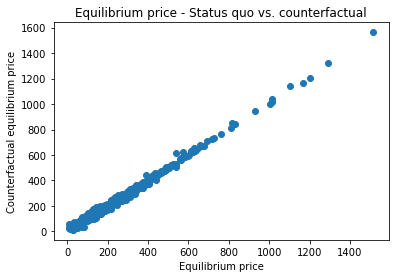

In [68]:
plt.scatter(res["price_ne"],res["price_cf"])
plt.xlabel("Equilibrium price")
plt.ylabel("Counterfactual equilibrium price")
plt.title("Equilibrium price - Status quo vs. counterfactual")

Text(0.5, 1.0, 'Equilibrium market shares - Status quo vs. counterfactual')

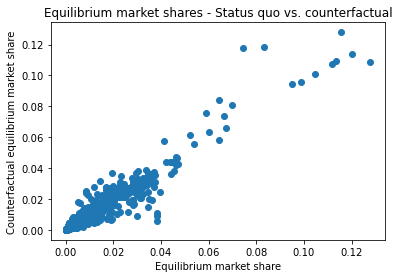

In [69]:
plt.scatter(res["market_share_ne"],res["market_share_cf"])
plt.xlabel("Equilibrium market share")
plt.ylabel("Counterfactual equilibrium market share")
plt.title("Equilibrium market shares - Status quo vs. counterfactual")

In [70]:
res.to_csv(r"welfare_eq_result_update_baseline_ch3.csv",index =False)

In [100]:
#df_data = pd.read_csv(r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare/welfare_eq_result_baseline.csv")

In [107]:
# calculate walfare
df_data["market_share_cf_delta_diff"] = df_data["market_share_cf"]*(rating_param*(df_data["Rating"] - df_data["exante_rating"])+alpha*(df_data["price_ne"]-df_data["price_cf"]))
#df_data["market_share_cf_delta_diff"] = df_data["market_share_cf"]*(df_data["quality"] - df_data["quality_without_review_fixed_price"])



diff = df_data.groupby(["month","year"])["market_share_cf_delta_diff"].sum().reset_index().rename(columns={"market_share_cf_delta_diff":"diff_term"})
temp = df_data.merge(diff,on=["month","year"], how="left")

df_3 = temp
    

In [108]:
df_3["r_greater_exante"] = df_3["exante_rating"]<df_3["Rating"]

df_3["rating_diff_exante"] =  df_3["Rating"]-df_3["exante_rating"]
df_3["market_share_percent_diff"] = (df_3["market_share_cf"] - df_3["market_share"])/df_3["market_share"]



In [109]:
df_cs = df_3[["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term"]].drop_duplicates()

df_cs["cs"] = (np.log(1+df_cs["D_g_sum_ne"]) - np.log(1+df_cs["D_g_sum_cf"])-df_cs["diff_term"])/alpha


avg_rating = df_3.groupby(["Market","year","month"])["Rating"].mean().reset_index()
avg_exante_rating = df_3.groupby(["Market","year","month"])["exante_rating"].mean().reset_index()
avg_diff_rating = df_3.groupby(["Market","year","month"])["rating_diff_exante"].mean().reset_index()
hotel_count = df_3.groupby(["Market","year","month"])["shareid"].nunique().reset_index()
hotel_better_than_exp = df_3[df_3["r_greater_exante"]==1].groupby(["Market","year","month"])["shareid"].nunique().reset_index()
market_share_percent_diff = df_3.groupby(["Market","year","month"])["market_share_percent_diff"].mean().reset_index()

df_cs = df_cs.merge(avg_diff_rating,\
            on=["Market","year","month"]).merge(avg_rating,\
    on=["Market","year","month"]).merge(avg_exante_rating,\
        on=["Market","year","month"]).merge(hotel_count,\
    on=["Market","year","month"]).merge(hotel_better_than_exp,\
        on=["Market","year","month"]).merge(market_share_percent_diff, on=["Market","year","month"])
#df_cs["% better than expected"] = df_cs["shareid_y"]/df_cs["shareid_x"]
df_cs


,Market,year,month,Market Monthly Supply,D_g_sum_ne,D_g_sum_cf,diff_term,cs,rating_diff_exante,Rating,exante_rating,shareid_x,shareid_y,market_share_percent_diff
0,"Chicago, IL",2016,1,1176605.0,0.808273,0.644751,0.314825,14.568573,3.196744,4.196744,1.0,105,105,-0.098396
1,"Chicago, IL",2016,2,1100678.0,0.995903,0.773111,0.325007,13.681709,3.189565,4.189565,1.0,105,105,-0.047935
2,"Chicago, IL",2016,3,1175049.0,2.118571,1.681079,0.391637,15.921858,3.196611,4.196611,1.0,104,104,-0.027064
3,"Chicago, IL",2016,4,1143704.0,2.923324,2.319737,0.363335,12.995426,3.205428,4.205428,1.0,104,104,-0.000254
4,"Chicago, IL",2016,5,1180280.0,3.923145,3.064503,0.378330,12.359347,3.209568,4.209568,1.0,103,103,0.043666
5,"Chicago, IL",2016,6,1154176.0,5.689894,4.481793,0.383351,12.194601,3.204892,4.204892,1.0,106,106,0.045510
6,"Chicago, IL",2016,7,1195017.0,6.690518,5.116331,0.399517,11.287951,3.202019,4.202019,1.0,106,106,0.097606
7,"Chicago, IL",2016,8,1197300.0,4.993102,3.926451,0.362298,11.010913,3.200553,4.200553,1.0,107,107,0.032323
8,"Chicago, IL",2016,9,1165230.0,4.823822,3.863437,0.322154,9.397797,3.207021,4.207021,1.0,108,108,0.006746
9,"Chicago, IL",2016,10,1210161.0,5.619173,4.478590,0.289221,6.627344,3.206639,4.206639,1.0,109,109,0.015878


In [110]:
market_size = df.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})

df_cs = df_cs.merge(market_size, on="Market")

df_cs["month_cs"] = df_cs["cs"]*df_cs["market_size"]

df_cs.groupby("Market")["month_cs"].sum()


Market
Chicago, IL          1.712786e+08
Houston, TX          2.408559e+08
Miami/Hialeah, FL    4.836190e+07
Name: month_cs, dtype: float64

In [111]:
market_size = df.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})
max_cs = df_cs.groupby("Market")["cs"].max().reset_index().rename(columns={"cs":"max_cs"})
min_cs = df_cs.groupby("Market")["cs"].min().reset_index().rename(columns={"cs":"min_cs"})
mean_cs = df_cs.groupby("Market")["cs"].mean().reset_index().rename(columns={"cs":"mean_cs"})

cs = market_size.merge(max_cs, on="Market").merge(min_cs, on="Market").merge(mean_cs,on="Market")
cs["total_cs"] = cs["market_size"]*cs["mean_cs"]*12/1000000
cs

,Market,market_size,max_cs,min_cs,mean_cs,total_cs
0,"Chicago, IL",1210161.0,15.921858,6.627344,11.794479,171.278624
1,"Houston, TX",1419322.0,17.421020,9.978923,14.141489,240.855912
2,"Miami/Hialeah, FL",325922.6,15.061355,6.175199,12.365385,48.361901


In [106]:
df_cs["cs"].mean()*(1210161+1436018+325923)*12

-13260999.707453843

In [107]:
df_3 = df_3.merge(df_cs, on=["Market","year","month","Market Monthly Supply","D_g_sum_ne","D_g_sum_cf","diff_term","market_size"])


In [108]:
# calculate weighted market share percent change

weights = df_3[["Market","shareid","month","capacity"]].drop_duplicates()
market_capacity = weights.groupby(["Market","month"])["capacity"].sum().reset_index().rename(columns={"capacity":"capacity_market"})
weights = weights.merge(market_capacity, on=["Market","month"], how="left")
weights["weights"] = weights["capacity"]/weights["capacity_market"]


In [109]:
df_3 = df_3.merge(weights[["Market","month","shareid","weights"]], on=["Market","month","shareid"], how="left")

In [110]:
#df_3["weights"] = df_3["market_share"]/(1-df_3["s_0"])

In [136]:

df_3["market_share_percent_diff"] = (df_3["market_share_cf"] - df_3["market_share_ne"])/df_3["market_share_ne"]
df_3["market_share_diff"] = df_3["market_share_cf"] - df_3["market_share_ne"]
#df_3["market_share_percent_diff_weighted"] =df_3["market_share_percent_diff"]*df_3["weights"]
#market_share_change = df_3.groupby(["shareid","Market"])["market_share_percent_diff_weighted"].sum().reset_index()
#market_share_change.groupby(["Market"])["market_share_percent_diff_weighted"].mean().reset_index()

In [111]:
df_3["price_percent_diff"] = (df_3["price_cf"] - df_3["price_ne"])/df_3["price_ne"]

df_3.groupby(["Market","r_greater_exante"])["price_percent_diff"].mean().reset_index()

,Market,r_greater_exante,price_percent_diff
0,"Chicago, IL",False,0.000758
1,"Chicago, IL",True,-0.004440
2,"Houston, TX",False,0.002711
3,"Houston, TX",True,-0.002012
4,"Miami/Hialeah, FL",False,0.000350
5,"Miami/Hialeah, FL",True,0.000072


In [138]:
df_3.groupby("Market")["price_percent_diff"].mean().reset_index()

,Market,price_percent_diff
0,"Chicago, IL",-0.001574
1,"Houston, TX",0.000720
2,"Miami/Hialeah, FL",0.000251


In [137]:


total_market_share = df_3.groupby(["Market","month","r_greater_exante"])["market_share_diff"].sum().reset_index()
total_market_share.groupby(["Market","r_greater_exante"])["market_share_diff"].mean()

Market             r_greater_exante
Chicago, IL        False               0.001883
                   True               -0.001399
Houston, TX        False               0.006897
                   True               -0.007239
Miami/Hialeah, FL  False               0.002775
                   True               -0.002638
Name: market_share_diff, dtype: float64

In [132]:
df_3.groupby(["Market"])["market_share_diff"].mean().reset_index()

,Market,market_share_diff
0,"Chicago, IL",-0.000004
1,"Houston, TX",0.000001
2,"Miami/Hialeah, FL",-0.000002


In [93]:

df_3["rating_int"] = df_3["accum_rating"].round(0)
df_3["rating_int"] = df_3["rating_int"].clip(lower=2)
df_3["market_share_diff"] = df_3["market_share_ne"] - df_3["market_share_cf"]
#market_share_change = df_3.groupby(["shareid","rating_int"])["market_share_percent_diff_weighted"].sum().reset_index()
df_3.groupby(["Market","r_greater_exante"])["market_share_percent_diff"].mean().reset_index()

,Market,r_greater_exante,market_share_percent_diff
0,"Chicago, IL",False,0.161064
1,"Chicago, IL",True,0.000840
2,"Houston, TX",False,0.055480
3,"Houston, TX",True,0.039743
4,"Miami/Hialeah, FL",False,-0.008515
5,"Miami/Hialeah, FL",True,0.027972


In [94]:
df_3[df_3["market_share_percent_diff"]==df_3["market_share_percent_diff"].max()]["market_share_cf"]

1398    0.000013
Name: market_share_cf, dtype: float64

In [96]:
market_share_sum = df_3[["Market","month","s_0_ne","s_0_cf"]].drop_duplicates()
market_share_sum["s_0_diff"] = market_share_sum["s_0_cf"]-market_share_sum["s_0_ne"]
market_share_sum.groupby("Market")["s_0_diff"].mean()

Market
Chicago, IL         -0.000484
Houston, TX          0.000342
Miami/Hialeah, FL   -0.000137
Name: s_0_diff, dtype: float64

In [117]:
list(df_3.columns)

['index',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_st

In [124]:
df_3["Revenue_cf"] = df_3["market_share_cf"]*df_3["market_size"]*df_3["price_cf"]
df_3["Revenue_ne"] = df_3["market_share_ne"]*df_3["market_size"]*df_3["price_ne"]
df_3["revenue_diff"] = df_3["Revenue_cf"] - df_3["Revenue_ne"]
df_3.groupby("Market")["revenue_diff"].sum()/1000000

Market
Chicago, IL         -2.873041
Houston, TX          0.020232
Miami/Hialeah, FL   -0.040730
Name: revenue_diff, dtype: float64

In [125]:


df_3.groupby(["Market","r_greater_exante"])["revenue_diff"].sum()/1000000
                                        

Market             r_greater_exante
Chicago, IL        False                4.768852
                   True                -7.641893
Houston, TX        False               12.813703
                   True               -12.793471
Miami/Hialeah, FL  False                3.280244
                   True                -3.320974
Name: revenue_diff, dtype: float64

In [74]:
df_3["revenue_percent_diff"] = (df_3["Revenue_ne"] - df_3["Revenue_cf"])/df_3["Revenue_cf"]
df_3.groupby(["Class Group"])["revenue_percent_diff"].mean()

Class Group
economy_group    12645.760447
luxury_group        -0.002839
upscale_group        0.819396
Name: revenue_percent_diff, dtype: float64

In [128]:
df_3

,index,post_month,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,...,market_share_percent_diff_y,month_cs,weights,price_percent_diff,market_share_percent_diff,market_share_percent_diff_weighted,market_share_diff,Revenue_cf,Revenue_ne,revenue_diff
0,12,2016-01,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,...,-0.072949,-1.450867e+06,0.006582,-0.000112,-4.943000e-03,3.269493e-05,1.623772e-05,5.619444e+05,5.647994e+05,-2855.013238
1,435,2016-01,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,...,-0.072949,-1.450867e+06,0.008925,-0.000268,1.579521e-02,-1.387768e-04,-4.235413e-05,1.062465e+06,1.046225e+06,16240.307454
2,475,2016-01,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,...,-0.072949,-1.450867e+06,0.001053,-0.000021,7.958325e-07,-8.380678e-10,-6.926607e-10,2.592533e+05,2.592585e+05,-5.173245
3,851,2016-01,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,...,-0.072949,-1.450867e+06,0.005660,-0.000118,1.434786e-02,-8.006386e-05,-1.999992e-05,5.884217e+05,5.801672e+05,8254.499327
4,1742,2016-01,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,...,-0.072949,-1.450867e+06,0.016059,-0.000373,6.281597e-04,-1.008150e-05,-4.663100e-06,1.851380e+06,1.850908e+06,471.821812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5373,4036,2016-12,3801491,2016-12-01,7750.0,6741.0,2133221.00,86.9806,316.454680,275.254323,...,0.000052,-1.448609e+05,0.024008,-0.003258,-1.546092e-02,3.770078e-04,3.266561e-04,2.144987e+06,2.185792e+06,-40805.303279
5374,4276,2016-12,4355335,2016-12-01,44640.0,27203.0,12391941.00,60.9386,455.535823,277.597245,...,0.000052,-1.448609e+05,0.138284,-0.007970,2.591295e-02,-3.492825e-03,-2.048505e-03,1.203691e+07,1.182713e+07,209776.070760
5375,5264,2016-12,5735666,2016-12-01,24490.0,19279.0,6602489.00,78.7219,342.470512,269.599388,...,0.000052,-1.448609e+05,0.075864,-0.008480,5.320479e-02,-3.832419e-03,-3.042438e-03,6.720112e+06,6.435202e+06,284910.165735
5376,5902,2016-12,7325223,2016-12-01,9114.0,7371.0,4662351.00,80.8755,632.526252,511.559250,...,0.000052,-1.448609e+05,0.028233,-0.002208,-1.112000e-02,3.174800e-04,2.543330e-04,4.661971e+06,4.724827e+06,-62856.222050


In [129]:
#calculate counterfactual outside share

market_share_sum = df_3.groupby(["Market","year","month","s_0_ne"])["market_share_cf"].sum().reset_index().rename(columns={"market_share_cf":"market_share_cf_sum"})

market_share_sum["s_0_cf"] = 1-market_share_sum["market_share_cf_sum"]

market_share_sum["s_0_diff"] = market_share_sum["s_0_cf"]-market_share_sum["s_0_ne"]

market_share_sum.groupby("Market")["s_0_diff"].mean()

Market
Chicago, IL         -0.000484
Houston, TX          0.000342
Miami/Hialeah, FL   -0.000137
Name: s_0_diff, dtype: float64

In [75]:
df_3["price_percent_diff"] = (df_3["price_ne"] - df_3["price_cf"])/df_3["price_cf"]
df_3.groupby(["Class Group"])["price_diff"].mean()

KeyError: 'Column not found: price_diff'

In [76]:
df_3["price_percent_diff"] = (df_3["price_ne"] - df_3["price_cf"])/df_3["price_cf"]
df_3.groupby(["Class Group","r_greater_exante"])["price_percent_diff"].mean()



Class Group    r_greater_exante
economy_group  False              -0.003851
               True                0.015504
luxury_group   False               0.001522
               True                0.004383
upscale_group  False              -0.002331
               True                0.009301
Name: price_percent_diff, dtype: float64

In [77]:

df_3.groupby(["Class Group"])["market_share_diff"].mean()

Class Group
economy_group    0.000002
luxury_group     0.000034
upscale_group    0.000032
Name: market_share_diff, dtype: float64

In [78]:
df_3.groupby(["Class Group","r_greater_exante"])["market_share_percent_diff"].mean()

Class Group    r_greater_exante
economy_group  False               882469.192561
               True                     0.038015
luxury_group   False                   -0.048300
               True                     0.012355
upscale_group  False                    6.651428
               True                     0.029340
Name: market_share_percent_diff, dtype: float64

In [79]:
upscale = df_3[df_3["Class Group"]=='upscale_group']
luxury["Revenue_ne"]-luxury["Revenue_cf"]

NameError: name 'luxury' is not defined

In [80]:

df_3.groupby(["Operation"])["revenue_percent_diff"].mean()

Operation
1    19740.539662
2        0.238282
3        1.868565
Name: revenue_percent_diff, dtype: float64

In [81]:
df_3.groupby(["Operation"])["market_share_percent_diff"].mean()

Operation
1    357103.448256
2         0.728446
3         4.535914
Name: market_share_percent_diff, dtype: float64

In [895]:
df_3.groupby(["Class Group"])["market_share_percent_diff"].mean()

Class Group
economy_group    3.178861
luxury_group    -0.002716
upscale_group    3.974777
Name: market_share_percent_diff, dtype: float64

In [878]:
df_3["price_diff"] = df_3["price_ne"]-df_3["price_cf"]
df_3.groupby(["Market"])["price_diff"].mean()

Market
Chicago, IL         -0.775220
Houston, TX          0.545473
Miami/Hialeah, FL   -0.012325
Name: price_diff, dtype: float64

In [879]:
df_3.groupby(["Market","r_greater_exante"])["price_diff"].mean()

Market             r_greater_exante
Chicago, IL        False              -1.012713
                   True               -0.184222
Houston, TX        False              -0.145034
                   True                1.476576
Miami/Hialeah, FL  False              -0.227768
                   True                0.415058
Name: price_diff, dtype: float64

In [884]:

df_3.groupby(["rating_int"])["market_share_percent_diff"].mean()

rating_int
2.0    2.950263
3.0    0.005682
4.0    4.500903
5.0    0.017089
Name: market_share_percent_diff, dtype: float64

In [292]:
df_4["price_diff"] = df_4["price_eq_cf"]-df_4["price_eq"]
df_4.groupby(["Market","r_greater_exante"])["price_diff"].mean()

Market             r_greater_exante
Chicago, IL        False               0.082101
                   True                0.064711
Houston, TX        False              -0.094534
                   True               -0.037857
Miami/Hialeah, FL  False              -1.480343
                   True               -1.705819
Name: price_diff, dtype: float64

In [293]:
df_4["delta_diff"] = df_4["delta_cf"] - df_4["delta"]
df_4.groupby(["rating_int"])["delta_diff"].mean()

rating_int
0.0   -0.000377
1.0    0.026756
2.0    0.003004
3.0   -0.004407
4.0   -0.001302
5.0    0.002025
Name: delta_diff, dtype: float64

In [289]:
df_4.groupby(["Market"])["delta_diff"].mean()

Market
Chicago, IL         -0.002225
Houston, TX         -0.004249
Miami/Hialeah, FL    0.017856
Name: delta_diff, dtype: float64

In [300]:

df.groupby(["Market","Operation"])["shareid"].nunique().to_csv(r"market_operation.csv")

In [301]:

df.groupby(["Market","Class"])["shareid"].nunique().to_csv(r"market_class.csv")

In [302]:
df.groupby(["Market","Class"])["shareid"].nunique()

Market             Class
Chicago, IL        1        17
                   2        50
                   3        27
                   4        15
                   5         6
                   6         5
Houston, TX        1         7
                   2        38
                   3        75
                   4        73
                   5        44
                   6        76
Miami/Hialeah, FL  1        22
                   2        25
                   3        18
                   4        10
                   5         9
                   6         4
Name: shareid, dtype: int64

In [303]:
df.groupby(["Market"])["shareid"].nunique()

Market
Chicago, IL          120
Houston, TX          313
Miami/Hialeah, FL     88
Name: shareid, dtype: int64

In [627]:
df_3.to_csv(r"welfare_eq_result.csv", index =False)

,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,Country,Market,...,D_g_sum_cf,market_share_cf,demand_cf,group_share_cf,market_share_sum_cf,s_0_cf,market_share_cf_delta_diff,diff_term,r_greater_exante,cs
0,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,United States,"Chicago, IL",...,0.675046,0.003362,4068.830465,0.058749,0.403001,0.596999,0.000023,-0.000820,True,-1.556186
1,88362,2016-01-01,10509.0,4055.0,1248453.00,38.5859,307.879901,118.798458,United States,"Chicago, IL",...,0.675046,0.002664,3223.504967,0.058749,0.403001,0.596999,0.000064,-0.000820,False,-1.556186
2,89959,2016-01-01,1240.0,817.0,202265.00,65.8870,247.570379,163.116935,United States,"Chicago, IL",...,0.675046,0.000870,1053.264639,0.058749,0.403001,0.596999,0.000015,-0.000820,True,-1.556186
3,94226,2016-01-01,5859.0,2274.0,743277.99,38.8120,326.859274,126.860896,United States,"Chicago, IL",...,0.675046,0.001339,1620.469895,0.058749,0.403001,0.596999,0.000055,-0.000820,False,-1.556186
4,105904,2016-01-01,18910.0,11718.0,2227185.00,61.9672,190.065284,117.778160,United States,"Chicago, IL",...,0.675046,0.007292,8824.084667,0.058749,0.403001,0.596999,0.000218,-0.000820,False,-1.556186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,3801491,2016-12-01,7750.0,6741.0,2133221.00,86.9806,316.454680,275.254323,United States,"Miami/Hialeah, FL",...,2.161487,0.021004,6845.665569,0.384134,0.683693,0.316307,-0.000115,-0.012126,False,-0.798074
5619,4355335,2016-12-01,44640.0,27203.0,12391941.00,60.9386,455.535823,277.597245,United States,"Miami/Hialeah, FL",...,2.161487,0.085086,27731.453623,0.384134,0.683693,0.316307,-0.002551,-0.012126,True,-0.798074
5620,5735666,2016-12-01,24490.0,19279.0,6602489.00,78.7219,342.470512,269.599388,United States,"Miami/Hialeah, FL",...,2.161487,0.047035,15329.761368,0.384134,0.683693,0.316307,0.004302,-0.012126,True,-0.798074
5621,7325223,2016-12-01,9114.0,7371.0,4662351.00,80.8755,632.526252,511.559250,United States,"Miami/Hialeah, FL",...,2.161487,0.022091,7199.801378,0.384134,0.683693,0.316307,0.000405,-0.012126,False,-0.798074


In [ ]:
# Scale market size

